In [ ]:
import os

from hydrolib import B17CEngine, Bulletin17C, PeakRecord, USGSGage, plot_frequency_curve

# Set output directory (outside repo)
output_dir = r"C:\Users\chrisj.nelson\hydro_output\gage_11066460"
os.makedirs(output_dir, exist_ok=True)

In [ ]:
site_no = "11066460"
gage = USGSGage(site_no)
gage.download_peak_flow()

print(f"Site: {gage.site_name}")
print(f"Site No: {gage.site_no}")
print(f"Drainage Area: {gage.drainage_area} sq mi")
print(f"Period of Record: {gage.period_of_record}")
print(f"Number of peaks: {len(gage.peak_data)}")

# View the data
print("\nPeak Flow Data:")
print(gage.peak_data)
# print(gage.peak_data.head(10))

Site: None
Site No: 11066460
Drainage Area: None sq mi
Period of Record: (1862, 2024)
Number of peaks: 56

Peak Flow Data:
    water_year  peak_date  peak_flow_cfs qualification_code
0         1862 1862-01-22         320000                5,7
1         1938 1938-03-02         100000                5,7
2         1971 1970-11-29           5300                  5
3         1972 1971-12-24           5290                  5
4         1973 1973-02-11           6950                  5
5         1974 1974-01-04           3300                  5
6         1975 1974-12-04           3600                5,C
7         1976 1976-09-11           9520                5,C
8         1977 1977-01-03           1640                5,C
9         1978 1978-03-04          19500                5,C
10        1979 1979-01-06           3850                5,C
11        1980 1980-01-11           3320                5,C
12        1981 1981-01-29           2910                5,C
13        1982 1982-03-18           5

In [ ]:
# Get records as PeakRecord objects for review
records = gage.get_peak_records()
print(f"\nTotal systematic records: {len(records)}")

# Review largest peaks
flows_sorted = sorted(records, key=lambda r: r.flow or 0, reverse=True)
print("\nTop 10 largest peaks:")
for i, r in enumerate(flows_sorted[:10], 1):
    print(f"  {i}. {r.year}: {r.flow:,.0f} cfs")

# Add historical peaks (example - adjust based on local knowledge)
# These are floods known to have occurred before systematic record
historical_peaks = [
    # (year, flow_cfs) - example historical floods
    # Uncomment and modify if you have historical data:
    # (1938, 45000),
    # (1916, 52000),
]


Total systematic records: 56

Top 10 largest peaks:
  1. 1862: 320,000 cfs
  2. 1938: 100,000 cfs
  3. 2011: 49,100 cfs
  4. 2005: 47,800 cfs
  5. 1998: 31,300 cfs
  6. 1995: 30,700 cfs
  7. 1983: 26,200 cfs
  8. 2010: 20,300 cfs
  9. 2017: 20,200 cfs
  10. 2004: 19,700 cfs


In [ ]:
# Extract arrays for Bulletin17C
peak_flows = gage.peak_data["peak_flow_cfs"].values
water_years = gage.peak_data["water_year"].values

# Create analysis with optional regional skew
# (Get regional skew from USGS regional skew map for your area)
# regional_skew = -0.50  # Example value - adjust for your region
# regional_skew_mse = 0.14  # Example MSE

regional_skew = None  # Use None to compute station skew only
regional_skew_mse = None  # Use None to compute station skew only

b17c = Bulletin17C(
    peak_flows,
    water_years=water_years,
    regional_skew=regional_skew,
    regional_skew_mse=regional_skew_mse,
    historical_peaks=historical_peaks if historical_peaks else None,
)

# Run EMA analysis
results = b17c.run_analysis(method="ema")

print("\n" + "=" * 50)
print("BULLETIN 17C ANALYSIS RESULTS")
print("=" * 50)
print(f"Method: {results.method.name}")
print(f"Sample size: {results.n_peaks}")
print(f"Systematic records: {results.n_systematic}")
print(f"Historical records: {results.n_historical}")
print(f"Low outliers: {results.n_low_outliers}")
print(f"\nLog-space statistics:")
print(f"  Mean (log10 Q): {results.mean_log:.4f}")
print(f"  Std Dev (log10 Q): {results.std_log:.4f}")
print(f"  Station Skew: {results.skew_station:.4f}")
if results.skew_weighted:
    print(f"  Weighted Skew: {results.skew_weighted:.4f}")
print(f"  Skew Used: {results.skew_used:.4f}")
if results.ema_converged is not None:
    print(f"\nEMA converged: {results.ema_converged} ({results.ema_iterations} iterations)")


BULLETIN 17C ANALYSIS RESULTS
Method: EMA
Sample size: 56
Systematic records: 56
Historical records: 0
Low outliers: 0

Log-space statistics:
  Mean (log10 Q): 3.8809
  Std Dev (log10 Q): 0.4598
  Station Skew: 1.0403
  Skew Used: 1.0403

EMA converged: True (1 iterations)


In [ ]:
print("\n" + "=" * 50)
print("FLOOD FREQUENCY TABLE")
print("=" * 50)

freq_table = b17c.compute_confidence_limits()
print(freq_table.to_string(index=False))


FLOOD FREQUENCY TABLE
  aep  return_period      flow_cfs    lower_5pct   upper_5pct
0.995       1.005025   1329.330947    860.022310 2.054738e+03
0.990       1.010101   1437.866086    943.270486 2.191799e+03
0.950       1.052632   1908.745955   1314.272821 2.772112e+03
0.900       1.111111   2325.407596   1652.557673 3.272213e+03
0.800       1.250000   3101.172966   2297.501464 4.185971e+03
0.500       2.000000   6361.539763   5025.583852 8.052634e+03
0.200       5.000000  16793.487840  12608.548951 2.236746e+04
0.100      10.000000  31233.309395  21394.924394 4.559584e+04
0.040      25.000000  66461.924157  39772.160716 1.110623e+05
0.020      50.000000 114291.256173  61626.860126 2.119610e+05
0.010     100.000000 193354.164716  93958.351066 3.978979e+05
0.005     200.000000 323277.657724 141655.072908 7.377670e+05
0.002     500.000000 629457.865999 240801.617336 1.645409e+06



Frequency curve saved to: C:\Users\chrisj.nelson\hydro_output\gage_11066460/frequency_curve.png


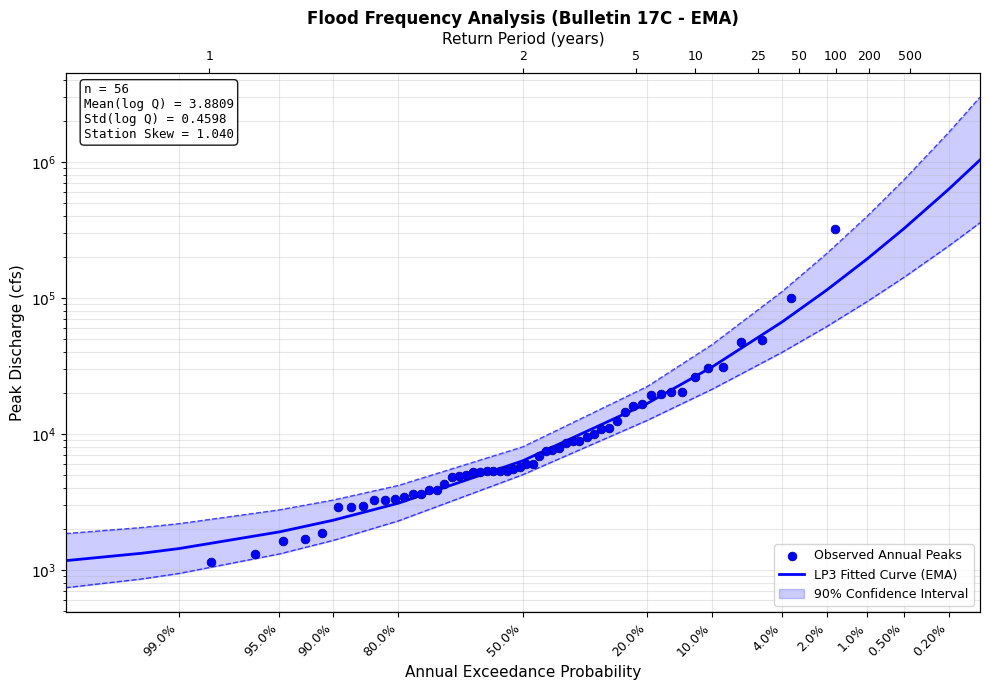

In [ ]:
fig = b17c.plot_frequency_curve(
    site_name=gage.site_name,
    site_no=gage.site_no,
    save_path=os.path.join(output_dir, "frequency_curve.png"),
    show_confidence=True,
)
print(f"\nFrequency curve saved to: {output_dir}/frequency_curve.png")

In [ ]:
engine = B17CEngine()
engine.fit(records)

print("\n" + "=" * 50)
print("B17C ENGINE SUMMARY")
print("=" * 50)
print(engine.summary())

# Get formatted frequency table
print("\nFrequency Table with 95% CI:")
print(engine.frequency_table().to_string(index=False))


B17C ENGINE SUMMARY
B17C Engine - LP3 Fit Summary
Sample size (n):     56
Mean (log10 Q):      3.8809
Std Dev (log10 Q):   0.4598
Skew coefficient:    0.9852

Key Quantiles:
  Q10  (10-yr):  31,416 cfs
  Q50  (50-yr):  111,378 cfs
  Q100 (100-yr): 184,624 cfs

Frequency Table with 95% CI:
 Return Period (yr)   AEP (%)    Flow (cfs)     Lower 95%    Upper 95%
                1.5 66.666667   4282.020914   3160.651911 5.801241e+03
                2.0 50.000000   6406.084660   4815.660285 8.521764e+03
                5.0 20.000000  16983.223017  12310.078475 2.343038e+04
               10.0 10.000000  31415.870007  21257.068669 4.642959e+04
               25.0  4.000000  65846.258155  40036.809535 1.082936e+05
               50.0  2.000000 111377.830272  62230.638911 1.993394e+05
              100.0  1.000000 184623.862502  94729.655906 3.598237e+05
              200.0  0.500000 301377.762173 142029.301089 6.395058e+05
              500.0  0.200000 565648.006742 238420.806421 1.341987e+06

In [ ]:
# Get the tables first
freq_table = b17c.compute_confidence_limits()
thresh_table = b17c.get_perception_thresholds_table()

weighted_skew_str = f"{results.skew_weighted:.4f}" if results.skew_weighted else "N/A"
drainage_str = f"{gage.drainage_area}" if gage.drainage_area else "N/A"
n_historical = len(historical_peaks) if historical_peaks else 0

report_text = f"""
# Flood Frequency Analysis Report
## USGS {gage.site_no} - {gage.site_name}

### Site Information
- Site Number: {gage.site_no}
- Site Name: {gage.site_name}
- Drainage Area: {drainage_str} sq mi
- Period of Record: {gage.period_of_record[0]} - {gage.period_of_record[1]}
- Number of Annual Peaks: {len(gage.peak_data)}

### Analysis Parameters
- Method: Bulletin 17C - {results.method.name}
- Regional Skew: {regional_skew:.3f}
- Regional Skew MSE: {regional_skew_mse:.3f}
- Historical Peaks: {n_historical}

### Log-Pearson Type III Statistics
- Mean (log10 Q): {results.mean_log:.4f}
- Std Dev (log10 Q): {results.std_log:.4f}
- Station Skew: {results.skew_station:.4f}
- Weighted Skew: {weighted_skew_str}
- Skew Used: {results.skew_used:.4f}
- Low Outlier Threshold: {results.low_outlier_threshold:,.0f} cfs
- Low Outliers Identified: {results.n_low_outliers}

### Flood Frequency Estimates
{freq_table.to_string(index=False)}

### Perception Thresholds
{thresh_table.to_string(index=False)}

---
*Analysis performed using hydrolib v0.0.3*
"""

report_path = os.path.join(output_dir, "flood_frequency_report.md")
with open(report_path, "w") as f:
    f.write(report_text)

print(f"\nReport saved to: {report_path}")

TypeError: unsupported format string passed to NoneType.__format__